## Time Gaps

Calculating intra- and inter-night gaps for several cadences

In [66]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.plots as plots 
import shutil

In [67]:
import matplotlib as mpl
mpl.rcParams['figure.autolayout'] = False

In [68]:
surveyDuration=1
if surveyDuration < 10:
    year = 3
    sqlconstraint = 'night between %f and %f' % ((365.25*year,365.25*(year+1)))
else:
    sqlconstraint = ''
if True:
    if len(sqlconstraint):
        sqlconstraint += ' and filter = "r"'
    else:
        sqlconstraint = 'filter = "r"'

In [69]:
# Pick a slicer
slicer = slicers.HealpixSlicer(nside=16)

# Configure some metrics
metricList = []
# Intra-night gaps
m1 = metrics.IntraNightGapsMetric()
metricList.append(m1)
# Inter-night gaps
m2 = metrics.InterNightGapsMetric()
metricList.append(m2)
# Gap histogram
#m3 = metrics.AveGapMetric()
#metricList.append(m3)

# summaryMetrics
summaryMetrics = [metrics.MinMetric(), metrics.MeanMetric(), metrics.MaxMetric(), 
                  metrics.MedianMetric(), metrics.RmsMetric(), 
                 metrics.PercentileMetric(percentile=25), metrics.PercentileMetric(percentile=75)]

# suppress angular power spectrum plots
plotFuncs = [plots.HealpixSkyMap(), plots.HealpixHistogram()]

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes


minion_1016
Querying database with constraint night between 1095.750000 and 1461.000000 and filter = "r"
Found 64247 visits
Running:  [0, 1]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with night between 1095.750000 and 1461.000000 and filter = "r" sqlconstraint now.
Plotting complete.
enigma_1282
Querying database with constraint night between 1095.750000 and 1461.000000 and filter = "r"
Found 58279 visits
Running:  [0, 1]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with night between 1095.750000 and 1461.000000 and filter = "r" sqlconstraint now.
Plotting complete.


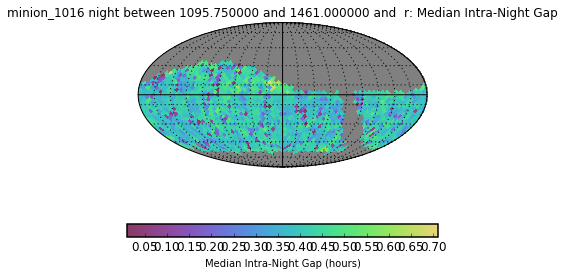

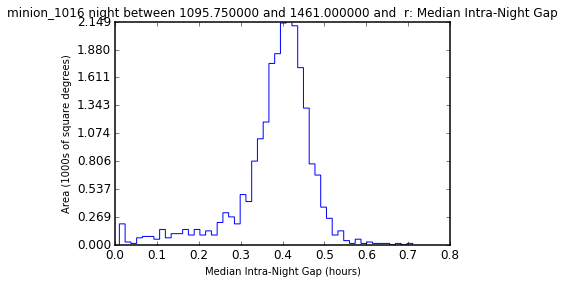

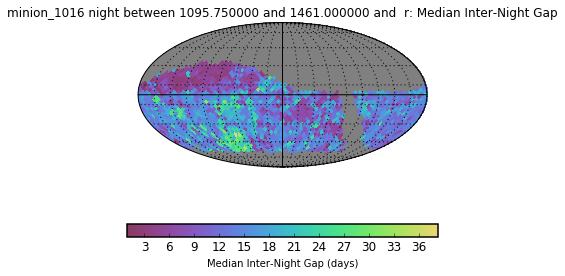

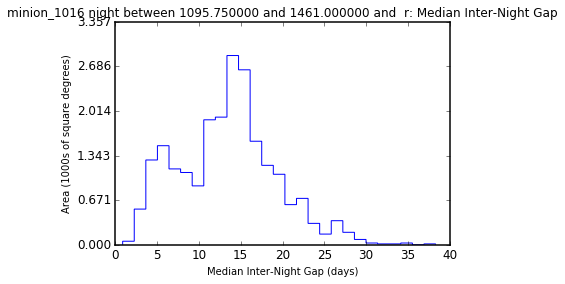

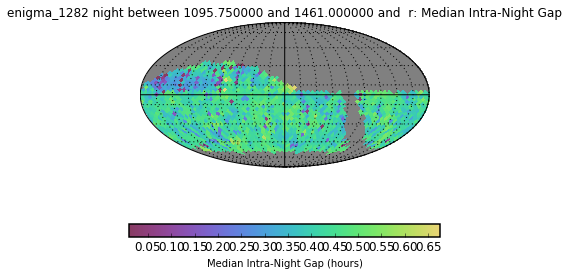

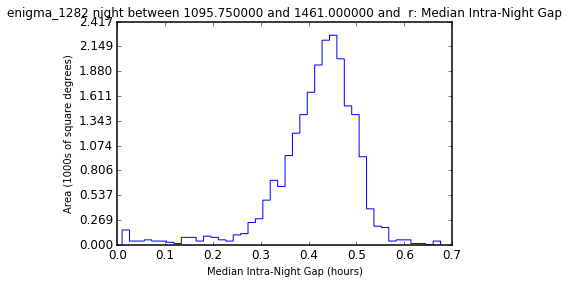

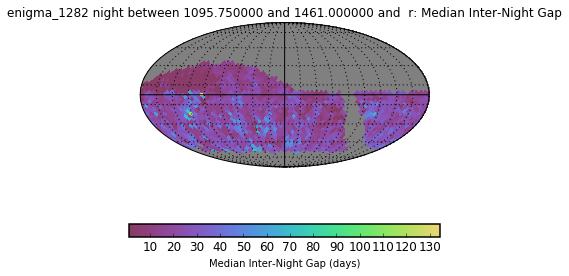

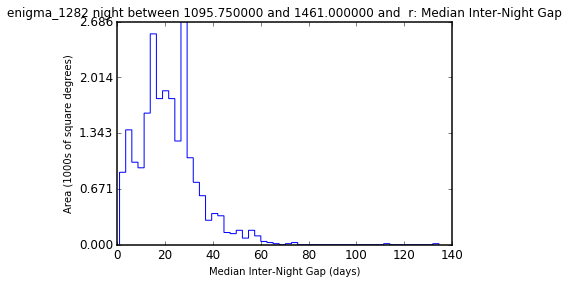

In [79]:
# Choose the opsim runs and do them all!
runs = ['minion_1016', # baseline cadence
        'enigma_1282'] # NEO with triples

outDir = 'gaps'

# resultsdb will contain multiple runs with various values if we change sqlconstraints, etc.  Instead, delete so 
# we have a clean directory

shutil.rmtree('./'+outDir+'/')

bDictDict = {}

for runName in runs:
    print runName
    opsdb = db.OpsimDatabase(runName + '_sqlite.db')
    resultsDb = db.ResultsDb(outDir=outDir)
    
    # build the bundleDict
    bDict={}
    for i,metric in enumerate(metricList):
        bDict[i] = metricBundles.MetricBundle(metric, slicer, sqlconstraint, 
            runName=runName, summaryMetrics=summaryMetrics, plotFuncs=plotFuncs)

    bgroup = metricBundles.MetricBundleGroup(bDict, opsdb, outDir=outDir, resultsDb=resultsDb)
    bgroup.runAll()
    bgroup.plotAll(closefigs=False)
    bDictDict[runName] = bDict

In [89]:
for runName in runs:
    print runName
    bDict = bDictDict[runName]
    for key in sorted(bDict):
        bDict[key].computeSummaryStats(resultsDb=resultsDb)
        print bDict[key].metric.name, bDict[key].summaryValues
    print 

minion_1016
Median Intra-Night Gap {'25th%ile': 0.35548500002914807, 'Rms': 0.092699674688065753, '75th%ile': 0.4361759999737842, 'Min': 0.01000799989560619, 'Max': 0.71104799991007894, 'Median': 0.40109399992797989, 'Mean': 0.38314876642335632}
Median Inter-Night Gap {'25th%ile': 9.0022895000010976, 'Rms': 5.83203365145721, '75th%ile': 16.930966624999201, 'Min': 0.90140600000086124, 'Max': 38.284016500001599, 'Median': 13.866831999999704, 'Mean': 13.471007432785838}

enigma_1282
Median Intra-Night Gap {'25th%ile': 0.38007899999502115, 'Rms': 0.088243450856106923, '75th%ile': 0.47020199992402922, 'Min': 0.01000799989560619, 'Max': 0.67595999999321066, 'Median': 0.43123200000263751, 'Mean': 0.41586294505523858}
Median Inter-Night Gap {'25th%ile': 13.115148500000942, 'Rms': 12.485629484194133, '75th%ile': 28.019349500002136, 'Min': 0.96774999999615829, 'Max': 134.52738000000318, 'Median': 19.982143000001088, 'Mean': 21.485495702810002}



In [97]:
bDict[0].metric.name

'Median Intra-Night Gap'

In [98]:
# loop over runs to make a new bundle list with only the right metrics
metricName = 'Median Intra-Night Gap'
new_bundle = []
for runName in runs:
    bDict = bDictDict[runName]
    for key in sorted(bDict):
        bDict[key].computeSummaryStats(resultsDb=resultsDb)
        if bDict[key].metric.name == metricName:
            new_bundle.append(bDict[key])

1

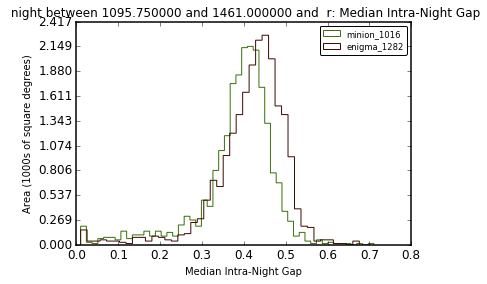

In [99]:
# Set up the plotHandler.
ph = plots.PlotHandler(outDir=outDir, resultsDb=resultsDb)
# Instantiate the healpix histogram plotter, since we'll use it a lot.
healpixhist = plots.HealpixHistogram()
ph.setMetricBundles(new_bundle)
# Add min/max values to the plots, which will be used for the combo histogram for nvisits.
#ph.setPlotDicts(nvisitsPlotRanges)
ph.plot(plotFunc=healpixhist)

In [72]:
rundb = db.ResultsDb(database=outDir+'/resultsDb_sqlite.db')

In [73]:
import pandas as pd

In [74]:
simDataName = [m[0] for m in rundb.session.query(db.MetricRow.simDataName).all()]
info = rundb.getMetricDisplayInfo()
dfi = pd.DataFrame(info)
dfi['simDataName'] = pd.Series(simDataName,index=dfi.index)
dfi.head()

,metricId,metricName,baseMetricNames,slicerName,sqlConstraint,metricMetadata,metricDatafile,displayGroup,displaySubgroup,displayOrder,displayCaption,simDataName
0,1,Median Intra-Night Gap,Median Intra-Night Gap,HealpixSlicer,night between 1095.750000 and 1461.000000 and ...,night between 1095.750000 and 1461.000000 and r,minion_1016_Median_Intra-Night_Gap_night_betwe...,NULL,NULL,0.0,Median Intra-Night Gap calculated on a Healpix...,minion_1016
1,2,Median Inter-Night Gap,Median Inter-Night Gap,HealpixSlicer,night between 1095.750000 and 1461.000000 and ...,night between 1095.750000 and 1461.000000 and r,minion_1016_Median_Inter-Night_Gap_night_betwe...,NULL,NULL,0.0,Median Inter-Night Gap calculated on a Healpix...,minion_1016
2,3,Median Intra-Night Gap,Median Intra-Night Gap,HealpixSlicer,night between 1095.750000 and 1461.000000 and ...,night between 1095.750000 and 1461.000000 and r,enigma_1282_Median_Intra-Night_Gap_night_betwe...,NULL,NULL,0.0,Median Intra-Night Gap calculated on a Healpix...,enigma_1282
3,4,Median Inter-Night Gap,Median Inter-Night Gap,HealpixSlicer,night between 1095.750000 and 1461.000000 and ...,night between 1095.750000 and 1461.000000 and r,enigma_1282_Median_Inter-Night_Gap_night_betwe...,NULL,NULL,0.0,Median Inter-Night Gap calculated on a Healpix...,enigma_1282


In [75]:
stats = rundb.getSummaryStats()
dfs = pd.DataFrame(stats)
dfs.head()

,metricId,metricName,slicerName,metricMetadata,summaryName,summaryValue
0,1,Median Intra-Night Gap,HealpixSlicer,night between 1095.750000 and 1461.000000 and r,Min,0.010008
1,1,Median Intra-Night Gap,HealpixSlicer,night between 1095.750000 and 1461.000000 and r,Mean,0.383149
2,1,Median Intra-Night Gap,HealpixSlicer,night between 1095.750000 and 1461.000000 and r,Max,0.711048
3,1,Median Intra-Night Gap,HealpixSlicer,night between 1095.750000 and 1461.000000 and r,Median,0.401094
4,1,Median Intra-Night Gap,HealpixSlicer,night between 1095.750000 and 1461.000000 and r,Rms,0.092700


In [76]:
df = pd.merge(dfs[['metricId','summaryName','summaryValue']],dfi,on='metricId')
df.head()

,metricId,summaryName,summaryValue,metricName,baseMetricNames,slicerName,sqlConstraint,metricMetadata,metricDatafile,displayGroup,displaySubgroup,displayOrder,displayCaption,simDataName
0,1,Min,0.010008,Median Intra-Night Gap,Median Intra-Night Gap,HealpixSlicer,night between 1095.750000 and 1461.000000 and ...,night between 1095.750000 and 1461.000000 and r,minion_1016_Median_Intra-Night_Gap_night_betwe...,NULL,NULL,0.0,Median Intra-Night Gap calculated on a Healpix...,minion_1016
1,1,Mean,0.383149,Median Intra-Night Gap,Median Intra-Night Gap,HealpixSlicer,night between 1095.750000 and 1461.000000 and ...,night between 1095.750000 and 1461.000000 and r,minion_1016_Median_Intra-Night_Gap_night_betwe...,NULL,NULL,0.0,Median Intra-Night Gap calculated on a Healpix...,minion_1016
2,1,Max,0.711048,Median Intra-Night Gap,Median Intra-Night Gap,HealpixSlicer,night between 1095.750000 and 1461.000000 and ...,night between 1095.750000 and 1461.000000 and r,minion_1016_Median_Intra-Night_Gap_night_betwe...,NULL,NULL,0.0,Median Intra-Night Gap calculated on a Healpix...,minion_1016
3,1,Median,0.401094,Median Intra-Night Gap,Median Intra-Night Gap,HealpixSlicer,night between 1095.750000 and 1461.000000 and ...,night between 1095.750000 and 1461.000000 and r,minion_1016_Median_Intra-Night_Gap_night_betwe...,NULL,NULL,0.0,Median Intra-Night Gap calculated on a Healpix...,minion_1016
4,1,Rms,0.092700,Median Intra-Night Gap,Median Intra-Night Gap,HealpixSlicer,night between 1095.750000 and 1461.000000 and ...,night between 1095.750000 and 1461.000000 and r,minion_1016_Median_Intra-Night_Gap_night_betwe...,NULL,NULL,0.0,Median Intra-Night Gap calculated on a Healpix...,minion_1016


In [77]:
print set(df['simDataName'])
print set(df['sqlConstraint'])
print set(df['metricName'])

set([u'minion_1016', u'enigma_1282'])
set(['night between 1095.750000 and 1461.000000 and filter = "r"'])
set(['Median Inter-Night Gap', 'Median Intra-Night Gap'])


In [78]:
for simName in set(df['simDataName']):
    print simName
    w = (df['simDataName'] == simName) & (df['sqlConstraint'] == 'night between 1095.750000 and 1461.000000 and filter = "r"') & (df['summaryName'] == 'Median')
    print df[w][['metricName','summaryValue']]

minion_1016
                metricName  summaryValue
3   Median Intra-Night Gap      0.401094
10  Median Inter-Night Gap     13.866832
enigma_1282
                metricName  summaryValue
17  Median Intra-Night Gap      0.431232
24  Median Inter-Night Gap     19.982143
